In [126]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box

from metloom.pointdata import SnotelPointData

In [17]:
ds = xr.open_dataset(Path('/bsuhome/zacharykeskinen/scratch/spicy-lowman-quadrant/combo_v3.nc'))
snotels = pd.read_csv('/bsuhome/zacharykeskinen/spicy-snow/contrib/keskinen/NRCS_SNOTEL_Locations_noAlaska.csv')
snotels = gpd.GeoDataFrame(snotels, geometry=gpd.points_from_xy(snotels.Longitude, snotels.Latitude), crs="EPSG:4326")
spicy_snotels = snotels[snotels.within(box(*ds.rio.bounds()))]

(42.6, 46.5)

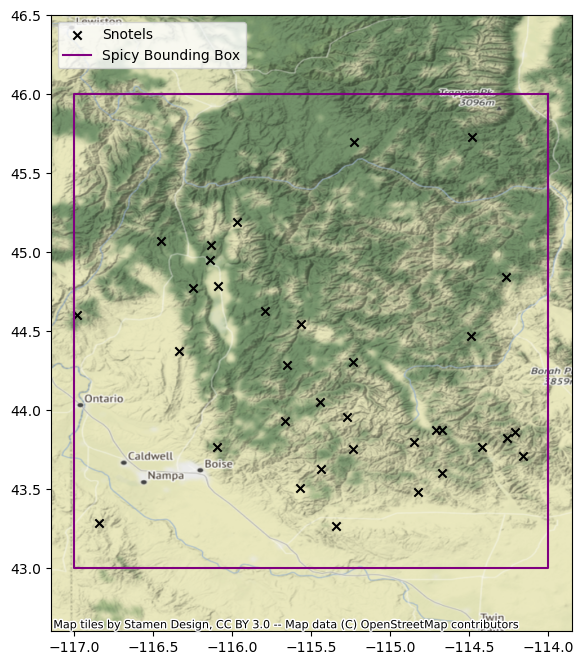

In [220]:
import contextily as ctx
fig, ax= plt.subplots(figsize = (12, 8))
spicy_snotels.plot(ax = ax, color = 'black', marker = 'x', label = 'Snotels')
x,y = box(*ds.rio.bounds()).exterior.xy
ax.plot(x,y, color = 'purple', label = 'Spicy Bounding Box')
plt.legend(loc = 'upper left')
ctx.add_basemap(ax = ax, crs = 'EPSG:4326')
plt.ylim(top = 46.5, bottom = 42.6)

In [204]:
t1 = pd.to_datetime(ds.time[0].data.ravel()[0])
t2 = pd.to_datetime(ds.time[-1].data.ravel()[0])

res = pd.DataFrame()
j = 0
for i, r in spicy_snotels.iterrows():
    # 100 m = 0.00090009 degrees
    tol = 0.00090009 * 5
    ds_site = ds.sel(x = slice(r.geometry.x - tol, r.geometry.x + tol), y = slice(r.geometry.y - tol, r.geometry.y + tol)).mean(dim = ['x','y'])
    snotel_point = SnotelPointData(f"{r['Station ID']}:{r['State']}:SNTL", r['Station Name'])
    sd = snotel_point.get_daily_data(t1, t2, [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]).reset_index(level = 1)
    for t in ds_site.time.data:
        spicy_sd = ds_site['snow_depth'].sel(time = t)
        if spicy_sd.isnull():
            continue
        t = pd.to_datetime(t).tz_localize('UTC')
        if t.month > 2:
            continue
        snotel_sd = sd[t - pd.Timedelta('1 day'): t]
        res.loc[j, 'site'] = r['Station Name']
        res.loc[j, 'date'] = t
        res.loc[j, 'spicy_sd'] = spicy_sd
        if snotel_sd['SNOWDEPTH_units'].values[0] == 'in':
            res.loc[j, 'snotel_sd'] = np.nanmean(snotel_sd['SNOWDEPTH'].values) * 0.0254 # convert inches to meters
            res.loc[j, 'snotel_sd_units'] = 'm'
        else:
            print(snotel_sd['SNOWDEPTH_units'].values[0])
            res.loc[j, 'snotel_sd'] = np.nanmean(snotel_sd['SNOWDEPTH'].values)
            res.loc[j, 'snotel_sd_units'] = snotel_sd['SNOWDEPTH_units'].values[0]
        j += 1

In [205]:
assert res.size == res[res.snotel_sd_units == 'm'].size

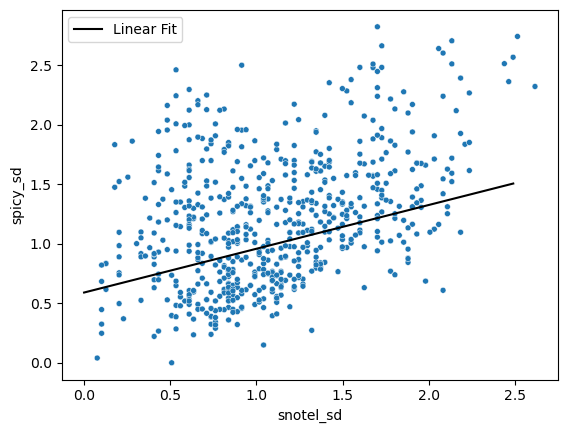

In [210]:
corrected = res.copy()
corrected['spicy_sd'] = res['spicy_sd']*0.84
sns.scatterplot(res, x = 'snotel_sd', y = 'spicy_sd', size = 1, legend=False)

from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(corrected.snotel_sd.values.reshape(-1, 1), corrected.spicy_sd.values.reshape(-1, 1))
xs = np.arange(0, 2.5, 0.01)
ys = LR.predict(xs.reshape(-1, 1))
plt.plot(xs, ys, color = 'black', label = 'Linear Fit')
plt.legend()

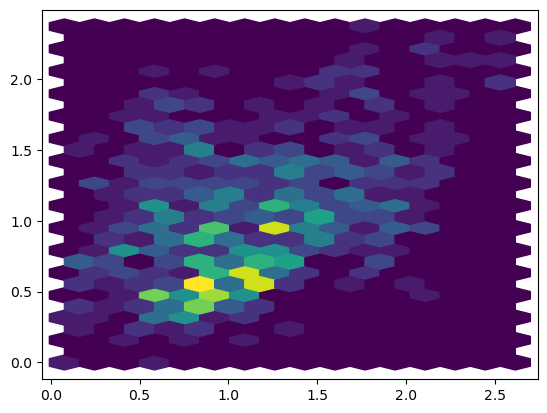

In [207]:
plt.hexbin(corrected.snotel_sd, corrected.spicy_sd, gridsize=(15,15))
plt.show()

0.84
0.5309561353168298


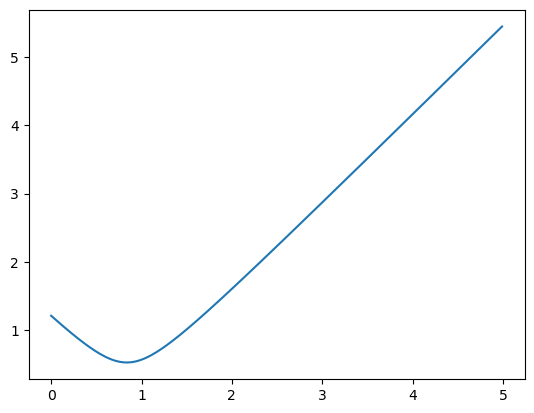

In [208]:
from sklearn.metrics import mean_squared_error
cs = np.arange(0, 5, 0.01)
rmses = np.zeros((2, len(cs)))
for i, c in enumerate(cs):
    rmse = mean_squared_error(res.snotel_sd.values, c*res.spicy_sd.values, squared=False)
    rmses[0, i] = rmse
    rmses[1, i] = c
plt.plot(rmses[1], rmses[0])
print(rmses[1][np.argmin(rmses[0])])
print(np.min(rmses[0]))

0.9400000000000001
0.0026641606471799317


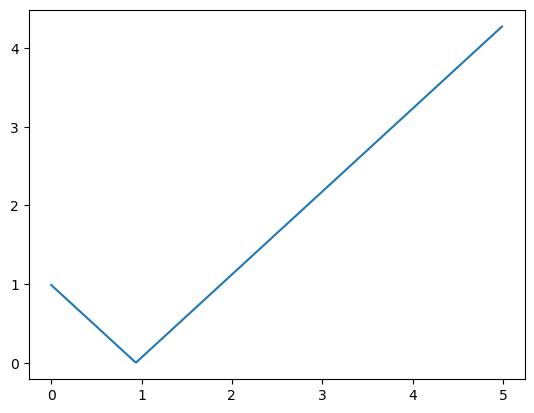

In [192]:
def mean_bias_error(true, pred):
    mbe_loss = np.mean(true - pred)
    return mbe_loss

from sklearn.metrics import mean_squared_error
cs = np.arange(0, 5, 0.01)
biases = np.zeros((2, len(cs)))
for i, c in enumerate(cs):
    bias = np.abs(mean_bias_error(res.snotel_sd.values, c*res.spicy_sd.values))
    biases[0, i] = bias
    biases[1, i] = c
plt.plot(biases[1], biases[0])
print(biases[1][np.argmin(biases[0])])
print(np.min(biases[0]))

In [193]:
mean_bias_error(corrected.snotel_sd.values, corrected.spicy_sd.values)

0.10279834121322445

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


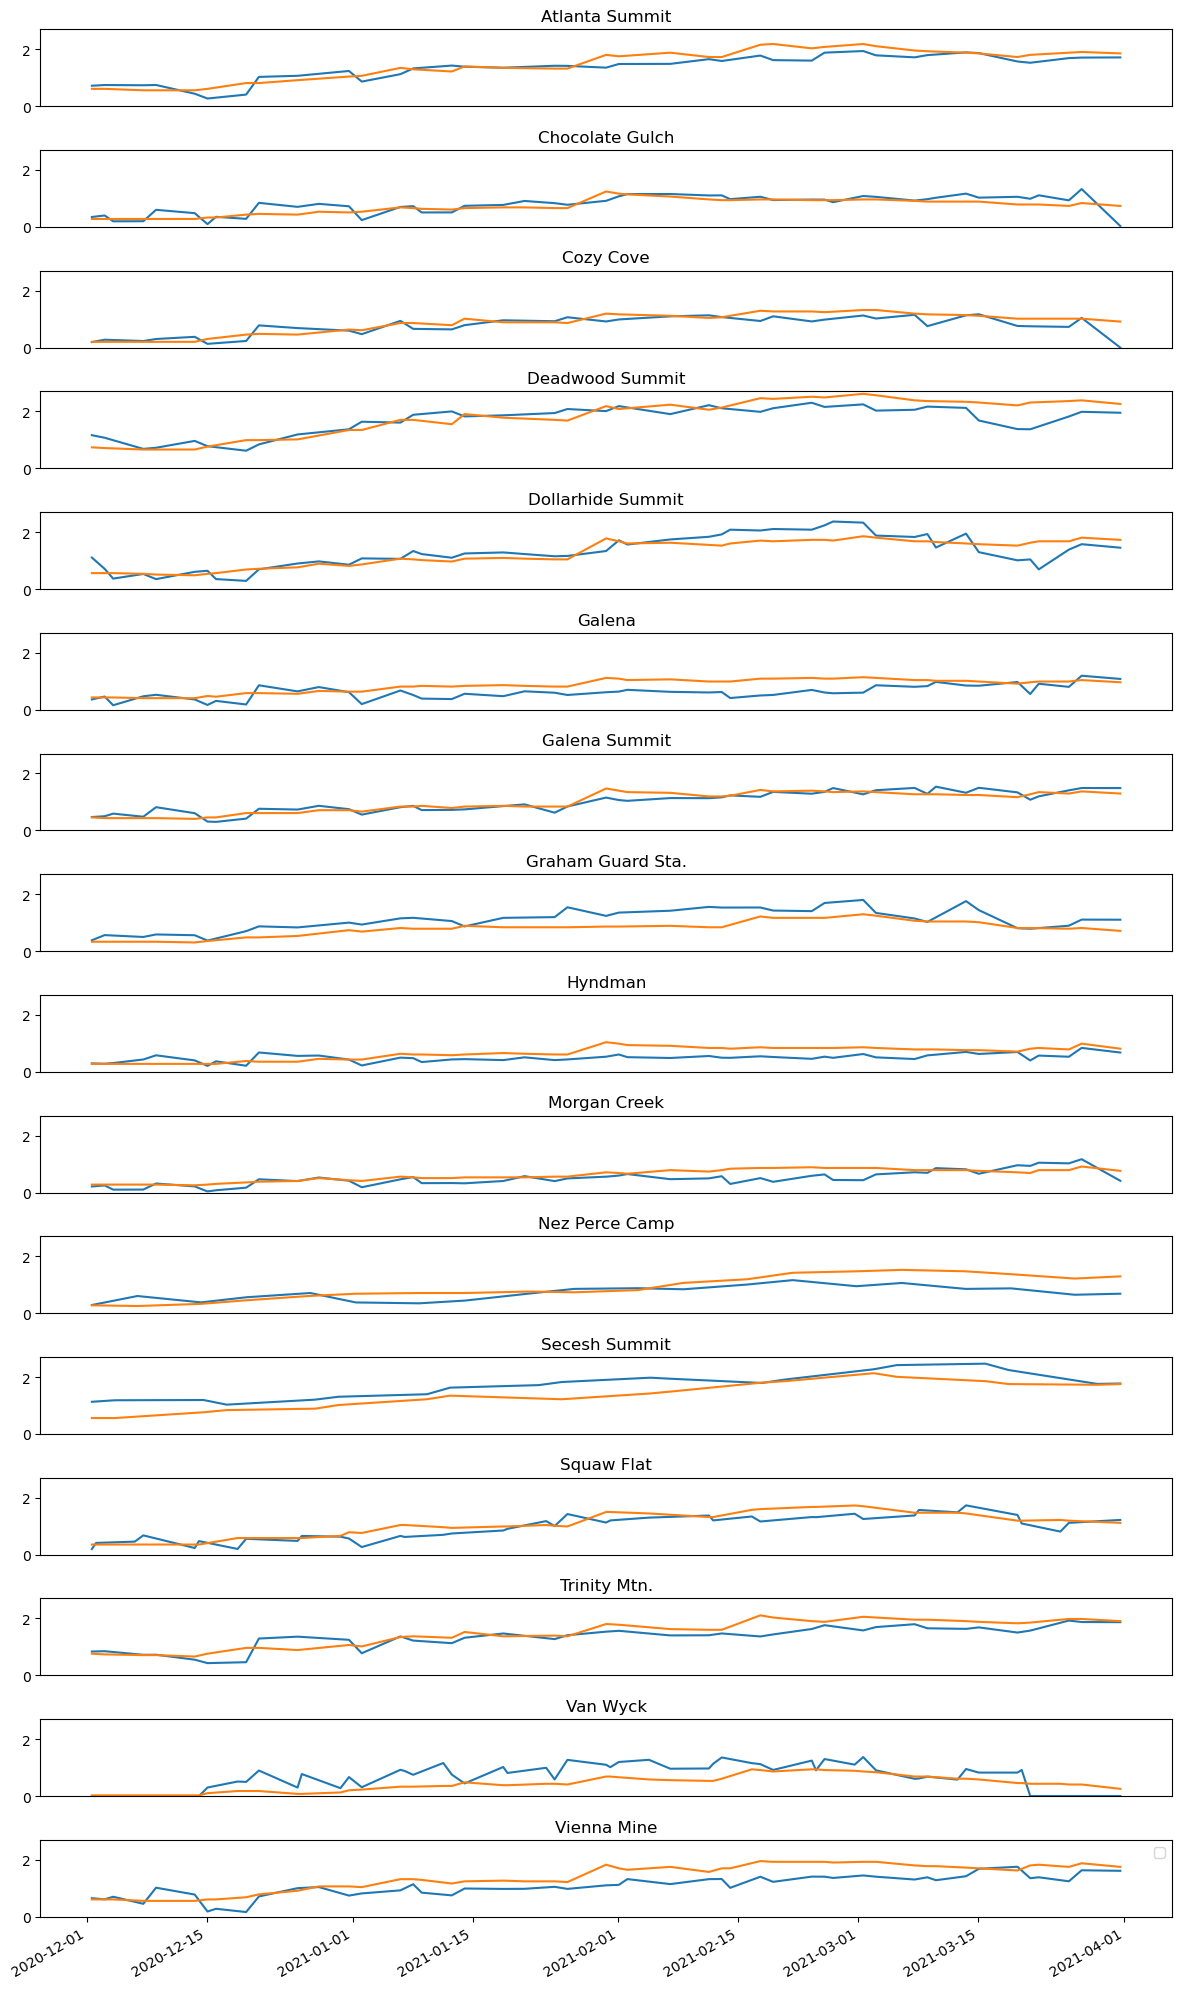

In [187]:
fig, axes = plt.subplots(16, figsize = (12, 20))
j = 0
for site_name, df in corrected.groupby('site'):
    rmse = mean_squared_error(df.snotel_sd.values, df.spicy_sd.values, squared=False)
    if rmse < 0.4:
        ax = axes[j]
        df = df.set_index('date')
        df['spicy_sd'].plot(label = 'Spicy', ax = ax)
        df['snotel_sd'].plot(label = 'Snotel', ax = ax)
        ax.set_xlabel('')
        if j != 15:
            ax.set_xticks([])
        ax.set_title(site_name)
        ax.set_ylim(0, 2.7)
        if j == 0:
            plt.legend()
        j += 1
plt.tight_layout()
